<a href="https://colab.research.google.com/github/dminhq98/extract_features_image/blob/master/extract_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

In [1]:
import urllib.request
urllib.request.urlretrieve('ftp://ftp.inrialpes.fr/pub/lear/douze/data/jpg1.tar.gz', 'jpg1.tar.gz')
urllib.request.urlretrieve('ftp://ftp.inrialpes.fr/pub/lear/douze/data/jpg2.tar.gz', 'jpg2.tar.gz')

('jpg2.tar.gz', <email.message.Message at 0x7fcb753184e0>)

In [0]:
import tarfile
my_tar = tarfile.open('jpg1.tar.gz')
my_tar.extractall() 
my_tar = tarfile.open('jpg2.tar.gz')
my_tar.extractall()
my_tar.close()

In [3]:
import urllib.request
urllib.request.urlretrieve('https://lear.inrialpes.fr/~jegou/code/eval_holidays.tgz', 'eval_holidays.tgz')


('eval_holidays.tgz', <http.client.HTTPMessage at 0x7fcb741f0b38>)

In [0]:
my_tar = tarfile.open('eval_holidays.tgz')
my_tar.extractall()
my_tar.close()

In [5]:
import os
os.listdir('/content/eval_holidays')

['he_wgc_result_200806.dat',
 'holidays_map.py',
 'holidays_images.dat',
 'perfect_result.dat',
 'README.txt',
 'baseline_result_200806.dat']

In [6]:
image_list = os.listdir('jpg')
print(image_list)
print(len(image_list))

['100503.jpg', '146302.jpg', '136103.jpg', '130300.jpg', '129101.jpg', '136203.jpg', '105500.jpg', '107202.jpg', '145502.jpg', '103601.jpg', '148301.jpg', '109300.jpg', '105700.jpg', '143800.jpg', '105501.jpg', '148202.jpg', '128800.jpg', '103203.jpg', '107601.jpg', '129700.jpg', '134503.jpg', '138306.jpg', '144402.jpg', '101200.jpg', '121700.jpg', '117402.jpg', '147802.jpg', '112902.jpg', '143803.jpg', '141201.jpg', '147701.jpg', '146301.jpg', '121300.jpg', '149901.jpg', '130700.jpg', '129300.jpg', '138006.jpg', '135701.jpg', '126400.jpg', '134001.jpg', '138603.jpg', '148101.jpg', '134002.jpg', '133901.jpg', '122705.jpg', '109801.jpg', '120901.jpg', '145201.jpg', '135502.jpg', '137504.jpg', '127501.jpg', '104200.jpg', '147301.jpg', '115800.jpg', '139201.jpg', '118701.jpg', '125500.jpg', '136010.jpg', '144801.jpg', '131701.jpg', '103600.jpg', '139001.jpg', '138901.jpg', '116600.jpg', '118401.jpg', '108203.jpg', '143702.jpg', '126401.jpg', '102802.jpg', '132100.jpg', '147801.jpg', '1392

In [7]:
PATH = '/content/jpg'
PATH_EVAL = '/content/eval_holidays'
fileName='holidays_images.dat'
fnam = os.path.join(PATH_EVAL,fileName)
image_list = []
with open(fnam) as f:
    for line in f:
      line=line.split('\n')[0]
      image_list.append(line)

print(image_list)
print(len(image_list))

['100000.jpg', '100001.jpg', '100002.jpg', '100100.jpg', '100101.jpg', '100200.jpg', '100201.jpg', '100300.jpg', '100301.jpg', '100302.jpg', '100400.jpg', '100401.jpg', '100500.jpg', '100501.jpg', '100502.jpg', '100503.jpg', '100600.jpg', '100601.jpg', '100700.jpg', '100701.jpg', '100800.jpg', '100801.jpg', '100900.jpg', '100901.jpg', '100902.jpg', '101000.jpg', '101001.jpg', '101100.jpg', '101101.jpg', '101200.jpg', '101201.jpg', '101300.jpg', '101301.jpg', '101400.jpg', '101401.jpg', '101402.jpg', '101403.jpg', '101404.jpg', '101500.jpg', '101501.jpg', '101502.jpg', '101503.jpg', '101504.jpg', '101600.jpg', '101601.jpg', '101700.jpg', '101701.jpg', '101702.jpg', '101800.jpg', '101801.jpg', '101900.jpg', '101901.jpg', '102000.jpg', '102001.jpg', '102100.jpg', '102101.jpg', '102200.jpg', '102201.jpg', '102202.jpg', '102300.jpg', '102301.jpg', '102302.jpg', '102303.jpg', '102400.jpg', '102401.jpg', '102402.jpg', '102500.jpg', '102501.jpg', '102600.jpg', '102601.jpg', '102700.jpg', '1027

# Check file image

In [0]:
!mkdir err_file

In [0]:
from PIL import Image
import os
import shutil  
PATH_ERR = '/content/err_file'
for im in image_list:
  try:
    path = os.path.join(PATH,im)
    img = Image.open(path)
  except IOError:
    path_new = os.path.join(PATH_ERR,im)
    shutil.move(path,path_new)
    print(im)



# Etract Features

In [0]:
import argparse
import logging
import random
import sys
from os import path

import h5py
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch import nn
from torchvision.datasets.folder import default_loader
from tqdm import tqdm


In [0]:
model_names = sorted(
    name for name in models.__dict__
    if name.islower() and not name.startswith("__") and callable(
        models.__dict__[name]))


def load_model(model, model_file):
    checkpoint = torch.load(model_file)
    # Support for checkpoints saved by scripts based off of
    #   https://github.com/pytorch/examples/blob/master/imagenet/main.py
    if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
        checkpoint = checkpoint['state_dict']
    logging.info('Loading model from %s', model_file)
    model.load_state_dict(checkpoint, strict=False)

    missing_keys = set(model.state_dict().keys()) - set(checkpoint.keys())
    extra_keys = set(checkpoint.keys()) - set(model.state_dict().keys())
    if missing_keys:
        logging.info('Missing keys in --model-file: %s.', missing_keys)
    if extra_keys:
        logging.info('Extra keys ignored in --model-file: %s.', extra_keys)



class ListDataset(torch.utils.data.Dataset):
    def __init__(self,
                 images_list,
                 transform=None,
                 loader=default_loader):
        self.images_list = images_list
        self.loader = loader
        self.transform = transform

    def __getitem__(self, index):
        image_path = self.images_list[index]
        image = self.loader(image_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, image_path

    def __len__(self):
        return len(self.images_list)


def image_path_to_name(image_path):
    # return np.string_(path.splitext(path.basename(image_path))[0])
    parent, image_name = path.split(image_path)
    image_name = path.splitext(image_name)[0]
    parent = path.split(parent)[1]
    return path.join(parent, image_name)


def extract_features_to_disk(image_paths,
                             model,
                             batch_size,
                             workers,
                             output_hdf5):
    # Data loading code
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    dataset = ListDataset(image_paths,
                          transforms.Compose([
                              transforms.Resize(256),
                              transforms.CenterCrop(224),
                              transforms.ToTensor(),
                              normalize,
                          ]))
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=workers,
        pin_memory=True)

    features = {}
    for i, (input_data, paths) in enumerate(tqdm(loader)):
        input_var = torch.autograd.Variable(input_data, volatile=True).cuda()
        current_features = model(input_var).data.cpu().numpy()
        for j, image_path in enumerate(paths):
            features[image_path] = current_features[j].reshape(-1,)

    feature_shape = features[list(features.keys())[0]].shape
    logging.info('Feature shape: %s' % (feature_shape, ))
    logging.info('Outputting features')

    if sys.version_info >= (3, 0):
        string_type = h5py.special_dtype(vlen=str)
    else:
        string_type = h5py.special_dtype(vlen=unicode)  # noqa
    paths = features.keys()
    logging.info('Stacking features')
    features_stacked = np.vstack([features[path] for path in paths])
    logging.info('Output feature size: %s' % (features_stacked.shape, ))
    with h5py.File(output_hdf5, 'a') as f:
        f.create_dataset('features', data=features_stacked)
        f.create_dataset(
            'image_names',
            (len(paths), ),
            dtype=string_type)
        # For some reason, assigning the list directly causes an error, so we
        # assign it in a loop.
        for i, image_path in enumerate(paths):
            # f['image_names'][i] = image_path_to_name(image_path)
            f['image_names'][i] = image_path



def _set_logging(logging_filepath):
    """Setup logger to log to file and stdout."""
    log_format = '%(asctime)s.%(msecs).03d: %(message)s'
    date_format = '%H:%M:%S'

    root_logger = logging.getLogger()
    root_logger.setLevel(logging.INFO)

    file_handler = logging.FileHandler(logging_filepath)
    file_handler.setFormatter(
        logging.Formatter(log_format, datefmt=date_format))
    root_logger.addHandler(file_handler)

    console_handler = logging.StreamHandler()
    console_handler.setFormatter(
        logging.Formatter(log_format, datefmt=date_format))
    root_logger.addHandler(console_handler)

    logging.info('Writing log file to %s', logging_filepath)


In [12]:
images = []
for i in image_list:
  img = os.path.join(PATH,i)
  images.append(img)

model = models.resnet50(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])
model.cuda()
model.eval()

batch_size = 10
output_features = 'features.h5'
workers = 4

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 91.4MB/s]


In [13]:
extract_features_to_disk(images, model, batch_size,
                             workers, output_features)

100%|██████████| 150/150 [02:04<00:00,  1.21it/s]


# Loading extract features file

In [14]:
f = h5py.File('features.h5', 'r')
list(f.keys())

['features', 'image_names']

In [15]:
image_names = f['image_names']
print(image_names)
image_names = list(image_names)
print(image_names)

<HDF5 dataset "image_names": shape (1491,), type "|O">
['/content/jpg/100000.jpg', '/content/jpg/100001.jpg', '/content/jpg/100002.jpg', '/content/jpg/100100.jpg', '/content/jpg/100101.jpg', '/content/jpg/100200.jpg', '/content/jpg/100201.jpg', '/content/jpg/100300.jpg', '/content/jpg/100301.jpg', '/content/jpg/100302.jpg', '/content/jpg/100400.jpg', '/content/jpg/100401.jpg', '/content/jpg/100500.jpg', '/content/jpg/100501.jpg', '/content/jpg/100502.jpg', '/content/jpg/100503.jpg', '/content/jpg/100600.jpg', '/content/jpg/100601.jpg', '/content/jpg/100700.jpg', '/content/jpg/100701.jpg', '/content/jpg/100800.jpg', '/content/jpg/100801.jpg', '/content/jpg/100900.jpg', '/content/jpg/100901.jpg', '/content/jpg/100902.jpg', '/content/jpg/101000.jpg', '/content/jpg/101001.jpg', '/content/jpg/101100.jpg', '/content/jpg/101101.jpg', '/content/jpg/101200.jpg', '/content/jpg/101201.jpg', '/content/jpg/101300.jpg', '/content/jpg/101301.jpg', '/content/jpg/101400.jpg', '/content/jpg/101401.jpg',

In [16]:
features = f['features'][:]
print(features)
print(features.shape)

[[0.0294716  0.30109197 0.26875094 ... 0.19967167 0.26759    0.04698608]
 [0.04271772 0.13177615 0.23029736 ... 0.09266437 0.19028616 0.04290321]
 [0.21746466 0.48742154 0.35992417 ... 0.2469229  0.34283438 0.03235589]
 ...
 [0.05698566 0.6088028  0.41029683 ... 0.18588708 0.05933975 0.6253307 ]
 [0.37347963 0.571104   0.49921596 ... 0.02496262 0.21865661 0.5275916 ]
 [0.07715565 0.37471613 0.18715385 ... 0.31064498 0.09370042 0.1023506 ]]
(1491, 2048)


# Search Knn images

In [17]:
pip install annoy

     |████████████████████████████████| 645kB 5.0MB/s 
  Created wheel for annoy: filename=annoy-1.16.2-cp36-cp36m-linux_x86_64.whl size=310396 sha256=2ae3e3f37b00b132a0af5320e344b2a48b6446eea307595759c459dde877f5b0
  Stored in directory: /root/.cache/pip/wheels/d3/d7/68/3795670ef4c6781fc10df0d6cf83b922244aa28cd9489d1176
Successfully built annoy


In [18]:
from annoy import AnnoyIndex
import random

f = len(features[0])
t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
for i in range(len(features)):
    v = features[i]
    t.add_item(i, v)

t.build(10) # 10 trees
t.save('feature_space.ann')


u = AnnoyIndex(f, 'angular')
u.load('feature_space.ann') # super fast, will just mmap the file
print(u.get_nns_by_item(0, 1000)) # will find the 1000 nearest neighbors

[0, 1, 15, 2, 13, 14, 12, 314, 63, 313, 343, 309, 745, 359, 65, 7, 746, 312, 306, 357, 73, 356, 39, 383, 342, 1328, 1203, 335, 310, 381, 334, 1329, 311, 72, 332, 358, 333, 788, 317, 316, 915, 914, 336, 764, 330, 64, 318, 307, 1332, 761, 338, 38, 1331, 774, 315, 1029, 1204, 74, 124, 266, 384, 1028, 10, 382, 125, 432, 337, 910, 801, 9, 328, 265, 174, 431, 344, 800, 208, 222, 541, 42, 8, 1018, 331, 339, 1455, 1003, 40, 220, 304, 70, 221, 787, 542, 173, 1198, 1195, 543, 539, 996, 1001, 434, 150, 703, 1019, 68, 41, 843, 5, 758, 178, 447, 740, 1020, 303, 1082, 1441, 148, 1407, 329, 775, 1083, 302, 71, 366, 908, 308, 689, 516, 784, 433, 453, 803, 538, 1416, 370, 1448, 175, 319, 1199, 341, 207, 126, 802, 471, 1453, 741, 905, 151, 759, 1294, 1413, 399, 789, 176, 524, 1218, 535, 521, 804, 1084, 463, 1002, 1330, 907, 177, 470, 11, 147, 476, 1406, 783, 462, 671, 1197, 373, 264, 146, 400, 545, 1447, 670, 1280, 995, 1456, 911, 1021, 136, 499, 461, 263, 1015, 994, 1058, 1293, 1292, 1403, 991, 763, 90

In [19]:
normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    normalize,
                ])
path = image_names[0]
print(path)
img = Image.open(path)
image = transform(img).unsqueeze(0).cuda()
feature = model(image).data.cpu().numpy().reshape(-1,)
print(feature)

k = u.get_nns_by_vector(feature, 10, include_distances=True)
print(k)

/content/jpg/100000.jpg
[0.0294716  0.30109197 0.26875094 ... 0.19967167 0.26759    0.04698608]
([0, 1, 15, 2, 13, 14, 12, 314, 63, 313], [0.0, 0.27905645966529846, 0.31187212467193604, 0.333217591047287, 0.36226940155029297, 0.3715257942676544, 0.40573397278785706, 0.4619148373603821, 0.4699926972389221, 0.47093597054481506])


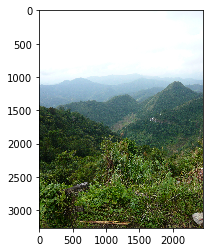

--------------------------------
Rank 1
Distance: 0.0


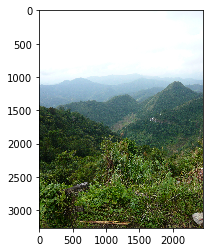

--------------------------------
Rank 2
Distance: 0.27905645966529846


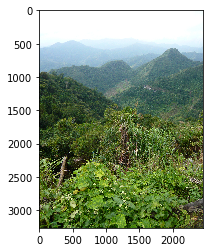

--------------------------------
Rank 3
Distance: 0.31187212467193604


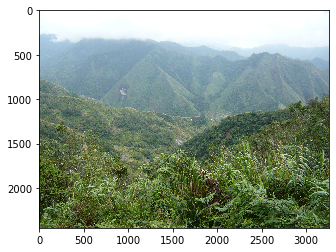

--------------------------------
Rank 4
Distance: 0.333217591047287


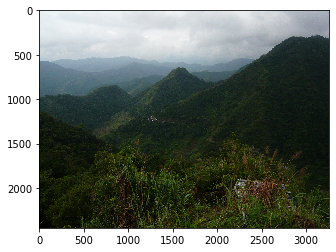

--------------------------------
Rank 5
Distance: 0.36226940155029297


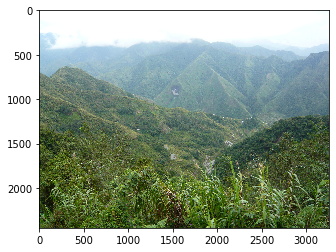

--------------------------------
Rank 6
Distance: 0.3715257942676544


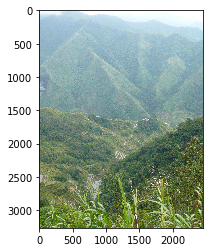

--------------------------------
Rank 7
Distance: 0.40573397278785706


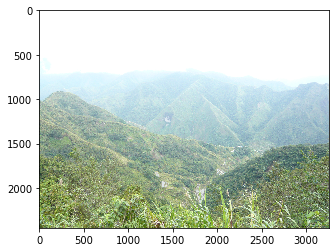

--------------------------------
Rank 8
Distance: 0.4619148373603821


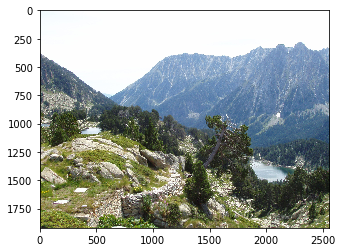

--------------------------------
Rank 9
Distance: 0.4699926972389221


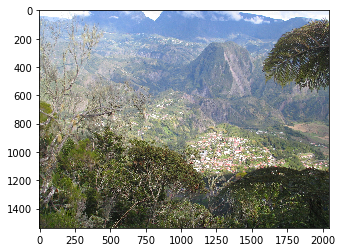

--------------------------------
Rank 10
Distance: 0.47093597054481506


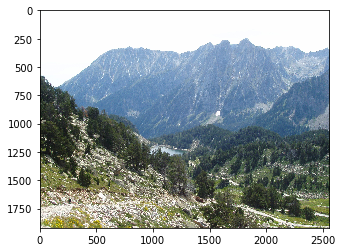

In [20]:
import matplotlib.pyplot as plt
path = image_names[0]
# img = cv2.imread(path)
img = Image.open(path)
plt.imshow(img)
plt.show()
for i,im in enumerate(k[0]):
  print('--------------------------------')
  print('Rank {}'.format(i+1))
  print('Distance: {}'.format(k[1][i]))
  path = image_names[im]
  img = Image.open(path)
  plt.imshow(img)
  plt.show()

In [21]:
file_name = 'perfect_result.dat'
fnam = os.path.join(PATH_EVAL,file_name)
query_list = []
with open(fnam) as f:
    for line in f:
      line = line.split(' ')[0]
      query_list.append(line)
print(query_list)
print(len(query_list))

['107100.jpg', '147800.jpg', '143000.jpg', '116400.jpg', '107900.jpg', '124300.jpg', '126000.jpg', '105100.jpg', '129700.jpg', '115500.jpg', '149500.jpg', '137600.jpg', '116600.jpg', '117600.jpg', '133300.jpg', '111800.jpg', '140900.jpg', '137000.jpg', '149800.jpg', '106300.jpg', '105400.jpg', '143300.jpg', '105200.jpg', '122800.jpg', '121900.jpg', '145500.jpg', '141700.jpg', '121600.jpg', '100800.jpg', '142900.jpg', '141200.jpg', '137500.jpg', '102300.jpg', '114200.jpg', '110400.jpg', '123800.jpg', '146000.jpg', '113300.jpg', '142100.jpg', '128900.jpg', '106400.jpg', '125100.jpg', '126900.jpg', '109500.jpg', '135500.jpg', '146400.jpg', '103800.jpg', '125700.jpg', '141600.jpg', '119800.jpg', '102000.jpg', '145100.jpg', '120200.jpg', '127300.jpg', '115900.jpg', '130300.jpg', '100000.jpg', '117300.jpg', '147900.jpg', '120100.jpg', '119100.jpg', '100500.jpg', '125200.jpg', '104500.jpg', '112800.jpg', '147000.jpg', '135700.jpg', '130700.jpg', '148800.jpg', '136600.jpg', '128700.jpg', '1011

In [22]:
query = []
for im in query_list:
  path = os.path.join(PATH,im)
  img = Image.open(path)
  image = transform(img).unsqueeze(0).cuda()
  feature = model(image).data.cpu().numpy().reshape(-1,) 
  query.append(feature)

query = np.asarray(query)
print(query.shape) 
print(query[0])

(500, 2048)
[0.10694991 0.433023   0.41015947 ... 0.55126864 0.77843195 0.4763188 ]


In [35]:
file_name = "result_test.dat"
file_name = os.path.join(PATH_EVAL,file_name)
with open(file_name, 'w') as f:
  for i,que in enumerate(query):
    k = u.get_nns_by_vector(que, 10)
    f.write(query_list[i])
    f.write(' ')
    for j,im in enumerate(k):
      f.write(str(j))
      f.write(' ')
      name = image_names[im]
      name = name.split('/')[-1]
      # print(name)
      f.write(name)
      f.write(' ')
    f.write('\n')
print("The results of 500 query  is saved in "+file_name)

The results of 500 query  is saved in /content/eval_holidays/result_test.dat


In [42]:
%cd eval_holidays/
!pwd

/content/eval_holidays
/content/eval_holidays


In [39]:
!python2 holidays_map.py result_test.dat

mAP for result_test.dat: 0.77607
